Cloning Efficientnet repository 

In [1]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 3.4 MB/s  eta 0:00:01


# Loading Packages

In [27]:
# import packages
import os, gc
import numpy as np
import pandas as pd
import glob
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from mlxtend.plotting import plot_confusion_matrix

# deep learning
import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: ', tf.__version__)
print(f'Keras Version: ', tf.keras.__version__)

Tensorflow Version:  2.2.0
Keras Version:  2.3.0-tf


# Preparing Data

## Training Data

In [3]:
data = Path('../input/covidpreprocesseddata/train_224x224-20200626T124445Z-001/train_224x224/')
os.listdir(data)

['Normal', 'Covid', 'Others']

In [4]:
for class_ in os.listdir(data):
    print(f'Number of train-val images in {class_}: {len(os.listdir(os.path.join(data, class_)))}')

Number of train-val images in Normal: 695
Number of train-val images in Covid: 695
Number of train-val images in Others: 611


Making dataframe from images inside directories. We will use this df to generate our folds.

In [5]:
# Paths to respective folders
normal = data / 'Normal'
covid = data / 'Covid'
others = data / 'Others'

# image files in respective dir
covid_cases = covid.glob('*.png')
normal_cases = normal.glob('*.png')
others_cases = others.glob('*.png')

train_data = []

for img in normal_cases:
    train_data.append((str(img), 'Normal'))
    
for img in covid_cases:
    train_data.append((str(img), 'Covid'))
    
for img in others_cases:
    train_data.append((str(img), 'Others'))

# making train_data dataframe    
train_data = pd.DataFrame(train_data, columns=['path', 'label'], index=None)
train_data

,path,label
0,../input/covidpreprocesseddata/train_224x224-2...,Normal
1,../input/covidpreprocesseddata/train_224x224-2...,Normal
2,../input/covidpreprocesseddata/train_224x224-2...,Normal
3,../input/covidpreprocesseddata/train_224x224-2...,Normal
4,../input/covidpreprocesseddata/train_224x224-2...,Normal
...,...,...
1996,../input/covidpreprocesseddata/train_224x224-2...,Others
1997,../input/covidpreprocesseddata/train_224x224-2...,Others
1998,../input/covidpreprocesseddata/train_224x224-2...,Others
1999,../input/covidpreprocesseddata/train_224x224-2...,Others


## Testing Data

In [6]:
test_data = Path('../input/covidpreprocesseddata/test-20200626T124450Z-001/test/')
os.listdir(test_data)

['Normal', 'Covid', 'Others']

In [7]:
for class_ in os.listdir(test_data):
    print(f'Number of test images in {class_}: {len(os.listdir(os.path.join(test_data, class_)))}')

Number of test images in Normal: 100
Number of test images in Covid: 100
Number of test images in Others: 100


In [8]:
# Preparing test data

normal_test = test_data / 'Normal'
covid_test = test_data / 'Covid'
others_test = test_data / 'Others'

covid_cases_test = covid_test.glob('*.png')
normal_cases_test = normal_test.glob('*.png')
others_cases_test = others_test.glob('*.png')

test_data = []

for img in normal_cases_test:
    test_data.append((str(img), 'Normal'))
    
for img in covid_cases_test:
    test_data.append((str(img), 'Covid'))
    
for img in others_cases_test:
    test_data.append((str(img), 'Others'))
    
# test_data dataframe    
test_data = pd.DataFrame(test_data, columns=['path', 'label'], index=None)
test_data

,path,label
0,../input/covidpreprocesseddata/test-20200626T1...,Normal
1,../input/covidpreprocesseddata/test-20200626T1...,Normal
2,../input/covidpreprocesseddata/test-20200626T1...,Normal
3,../input/covidpreprocesseddata/test-20200626T1...,Normal
4,../input/covidpreprocesseddata/test-20200626T1...,Normal
...,...,...
295,../input/covidpreprocesseddata/test-20200626T1...,Others
296,../input/covidpreprocesseddata/test-20200626T1...,Others
297,../input/covidpreprocesseddata/test-20200626T1...,Others
298,../input/covidpreprocesseddata/test-20200626T1...,Others


## K-folds Cross Validation

In [9]:
# k-fold cross -validation
train_data["kfold"] = -1    
train_data = train_data.sample(frac=1).reset_index(drop=True)
y = train_data.label.values
kf = StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=train_data, y=y)):
    train_data.loc[v_, 'kfold'] = f

# saving train_data with kfold column
train_data.to_csv("train_folds.csv", index=False)

In [10]:
train_data

,path,label,kfold
0,../input/covidpreprocesseddata/train_224x224-2...,Normal,0
1,../input/covidpreprocesseddata/train_224x224-2...,Normal,0
2,../input/covidpreprocesseddata/train_224x224-2...,Covid,0
3,../input/covidpreprocesseddata/train_224x224-2...,Others,0
4,../input/covidpreprocesseddata/train_224x224-2...,Normal,0
...,...,...,...
1996,../input/covidpreprocesseddata/train_224x224-2...,Normal,4
1997,../input/covidpreprocesseddata/train_224x224-2...,Covid,4
1998,../input/covidpreprocesseddata/train_224x224-2...,Covid,4
1999,../input/covidpreprocesseddata/train_224x224-2...,Normal,4


# Defining Hyper Parameters

In [11]:
IMAGE_WIDTH, IMAGE_HEIGTH = 224, 224
BATCH_SIZE = 32
BASE_LAYER = 744 # (block6m_add)
INPUT_TENSOR = (224, 224, 3)
OPT = Adam(learning_rate=1e-3)
LOSS = 'categorical_crossentropy'
FOLDS = 5
EPOCHS = 10

# Keras Data Generator

In [12]:
# train data generator
datagen_ = ImageDataGenerator(rescale=1./255,
                            zoom_range=0.2,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            validation_split=0.2)
# test data generator
test_ = ImageDataGenerator(rescale=1./255)

# Model: EfficientNetB7

In [13]:
# Defining model and compiling it.
def EffNetB7(input_tensor=INPUT_TENSOR, weights=None, trainable=BASE_LAYER, optimizer=OPT, loss=LOSS):
    
    base_model = efn.EfficientNetB7(weights=weights,
                               input_shape=input_tensor,
                               include_top=False)
    

    model_in = base_model.output
    global_avg = GlobalAveragePooling2D()(model_in)
    dense_5 = Dense(512, activation='relu')(global_avg)
    final = Dense(3, activation='softmax')(dense_5)
    model = Model(inputs=base_model.input, outputs=final)
    
    # training last layers
    print('\nFine-Tuning Model. Training last 2 blocks only...\n')
    for layer in model.layers[:trainable]:
        layer.trainable = False
        
    for layer in model.layers[trainable:]:
        layer.trainable = True
    
    # compiling model
    print('\nCompiling Model...\n')
    model.compile(optimizer = optimizer,
              loss = loss,
              metrics=['accuracy', 'AUC', Precision(), Recall()])
    
    return model

# Callbacks

In [14]:
# callback function
def get_callbacks(model_name, monitor = 'val_loss'):
    callbacks = []
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5',
                                                         monitor = monitor,
                                                         model = 'auto',
                                                         save_best_only = True)
    callbacks.append(model_checkpoint)
    
    return callbacks

In [15]:
gc.collect()

120

# Training

## Training On k-folds

In [16]:
# saved models path
model_path = '/kaggle/working/'

In [17]:
# setting counter 
count = 0

# training for kfolds
for fold in range(FOLDS):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_precisions = []
    train_recalls = []

    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_precisions = []
    val_recalls = []
    
    df_train = train_data[train_data.kfold != fold].reset_index(drop=True)
    df_valid = train_data[train_data.kfold == fold].reset_index(drop=True)
    
    print(f'fold-{count+1}', len(df_train), len(df_valid))
    
    # Train and Validation
    train_gen = datagen_.flow_from_dataframe(df_train,
                                            x_col='path',
                                            y_col='label',
                                            target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=2020,
                                            class_mode='categorical')

    val_gen = datagen_.flow_from_dataframe(df_valid,
                                            x_col='path',
                                            y_col='label',
                                            target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=2020,
                                            class_mode='categorical')
    
    # model
    model = EffNetB7(input_tensor=INPUT_TENSOR, weights='imagenet', trainable=BASE_LAYER, optimizer=OPT, loss=LOSS)
    
    # training
    model.fit(train_gen, 
              validation_data=val_gen,
              epochs=EPOCHS,
              callbacks=get_callbacks(f'covid_base_model_{count+1}'))
    
    # Training Evaluation
    print()
    print('Evaluating on training data...')
    train_loss, train_accuracy, train_auc, train_precision, train_recall = model.evaluate(train_gen)
    
    # Training Metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    
    #Validation Evaluating
    print()
    print('Evaluating on validation data...')
    model = load_model(os.path.join(model_path, f'covid_base_model_{count+1}.h5'))
    val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(val_gen)
    
    # Validation Metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print('##############################################################################')
    print()
    
    count+=1

fold-1 1600 401
Found 1600 validated image filenames belonging to 3 classes.
Found 401 validated image filenames belonging to 3 classes.
258441216/258434480 [==============================] - 9s 0us/step

Fine-Tuning Model. Training last 2 blocks only...


Compiling Model...

Epoch 1/10
50/50 [==============================] - 48s 953ms/step - loss: 1.1020 - accuracy: 0.5319 - auc: 0.7206 - precision: 0.5618 - recall: 0.4487 - val_loss: 0.9484 - val_accuracy: 0.5761 - val_auc: 0.7707 - val_precision: 0.7406 - val_recall: 0.3915
Epoch 2/10
50/50 [==============================] - 38s 755ms/step - loss: 0.7827 - accuracy: 0.6931 - auc: 0.8499 - precision: 0.7468 - recall: 0.6269 - val_loss: 0.7584 - val_accuracy: 0.6883 - val_auc: 0.8548 - val_precision: 0.7327 - val_recall: 0.6085
Epoch 3/10
50/50 [==============================] - 37s 747ms/step - loss: 0.6449 - accuracy: 0.7325 - auc: 0.8914 - precision: 0.7673 - recall: 0.6781 - val_loss: 0.7199 - val_accuracy: 0.6683 - val_auc: 0.87

Epoch 6/10
51/51 [==============================] - 37s 733ms/step - loss: 0.4976 - accuracy: 0.8114 - auc: 0.9338 - precision_2: 0.8384 - recall_2: 0.7745 - val_loss: 0.4975 - val_accuracy: 0.8000 - val_auc: 0.9364 - val_precision_2: 0.8179 - val_recall_2: 0.7975
Epoch 7/10
51/51 [==============================] - 37s 734ms/step - loss: 0.4721 - accuracy: 0.8226 - auc: 0.9415 - precision_2: 0.8494 - recall_2: 0.7926 - val_loss: 0.4524 - val_accuracy: 0.8250 - val_auc: 0.9466 - val_precision_2: 0.8480 - val_recall_2: 0.7950
Epoch 8/10
51/51 [==============================] - 35s 684ms/step - loss: 0.4425 - accuracy: 0.8276 - auc: 0.9476 - precision_2: 0.8494 - recall_2: 0.7889 - val_loss: 0.4949 - val_accuracy: 0.8150 - val_auc: 0.9404 - val_precision_2: 0.8311 - val_recall_2: 0.7875
Epoch 9/10
51/51 [==============================] - 34s 661ms/step - loss: 0.4130 - accuracy: 0.8382 - auc: 0.9544 - precision_2: 0.8598 - recall_2: 0.8157 - val_loss: 0.4722 - val_accuracy: 0.8150 - val_a

13/13 [==============================] - 6s 439ms/step - loss: 0.5166 - accuracy: 0.8050 - auc_4: 0.9369 - precision_4: 0.8117 - recall_4: 0.7975
##############################################################################



In [18]:
# getting index and layer name
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_5
1 stem_conv
2 stem_bn
3 stem_activation
4 block1a_dwconv
5 block1a_bn
6 block1a_activation
7 block1a_se_squeeze
8 block1a_se_reshape
9 block1a_se_reduce
10 block1a_se_expand
11 block1a_se_excite
12 block1a_project_conv
13 block1a_project_bn
14 block1b_dwconv
15 block1b_bn
16 block1b_activation
17 block1b_se_squeeze
18 block1b_se_reshape
19 block1b_se_reduce
20 block1b_se_expand
21 block1b_se_excite
22 block1b_project_conv
23 block1b_project_bn
24 block1b_drop
25 block1b_add
26 block1c_dwconv
27 block1c_bn
28 block1c_activation
29 block1c_se_squeeze
30 block1c_se_reshape
31 block1c_se_reduce
32 block1c_se_expand
33 block1c_se_excite
34 block1c_project_conv
35 block1c_project_bn
36 block1c_drop
37 block1c_add
38 block1d_dwconv
39 block1d_bn
40 block1d_activation
41 block1d_se_squeeze
42 block1d_se_reshape
43 block1d_se_reduce
44 block1d_se_expand
45 block1d_se_excite
46 block1d_project_conv
47 block1d_project_bn
48 block1d_drop
49 block1d_add
50 block2a_expand_conv
51 block2a_e

## Training Full Dataset

In [19]:
# data generator for training model on full dataset
full_gen = datagen_.flow_from_dataframe(train_data,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        seed=2020,
                                        class_mode='categorical')

# model
model = EffNetB7(input_tensor=INPUT_TENSOR, weights='imagenet', trainable=BASE_LAYER, optimizer=OPT, loss=LOSS)

# training model
print('\nTraining on full dataset...')
history = model.fit(full_gen,
                    epochs = 50,
                    callbacks = get_callbacks(f'covid_base_model_fulldata'))

Found 2001 validated image filenames belonging to 3 classes.

Fine-Tuning Model. Training last 2 blocks only...


Compiling Model...


Training on full dataset...
Epoch 1/50
63/63 [==============================] - 32s 512ms/step - loss: 1.2879 - accuracy: 0.5387 - auc: 0.7138 - precision_5: 0.5867 - recall_5: 0.4398
Epoch 2/50
63/63 [==============================] - 33s 528ms/step - loss: 0.7657 - accuracy: 0.6667 - auc: 0.8451 - precision_5: 0.7395 - recall_5: 0.5702
Epoch 3/50
63/63 [==============================] - 32s 507ms/step - loss: 0.6289 - accuracy: 0.7491 - auc: 0.8948 - precision_5: 0.7870 - recall_5: 0.6962
Epoch 4/50
63/63 [==============================] - 33s 525ms/step - loss: 0.5638 - accuracy: 0.7866 - auc: 0.9158 - precision_5: 0.8212 - recall_5: 0.7321
Epoch 5/50
63/63 [==============================] - 33s 517ms/step - loss: 0.5014 - accuracy: 0.8101 - auc: 0.9326 - precision_5: 0.8422 - recall_5: 0.7816
Epoch 6/50
63/63 [==============================] - 33s 5

<Figure size 432x288 with 0 Axes>

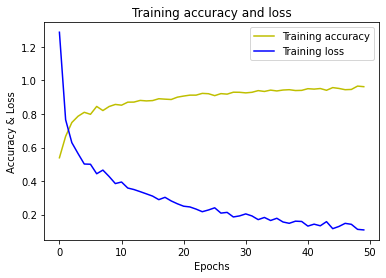

<Figure size 432x288 with 0 Axes>

In [46]:
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy and loss')
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('/kaggle/working/train_acc_loss.png', dpi=100)
plt.figure()

# Testing

In [20]:
# test generator
test_gen = test_.flow_from_dataframe(test_data,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        seed=2020,
                                        class_mode='categorical')


# Testing Evaluation
print()
print('Evaluating on testing data...')
test_loss, test_accuarcy, test_auc, test_precision, test_recall = model.evaluate(test_gen)

Found 300 validated image filenames belonging to 3 classes.

Evaluating on testing data...
10/10 [==============================] - 2s 211ms/step - loss: 0.9090 - accuracy: 0.8000 - auc: 0.9188 - precision_5: 0.7993 - recall_5: 0.7967


# Evaluation and Results

Training evaluation on kfolds. Taking average of all metrics produced by models trained on each fold for both training and validation data.

In [21]:
# Training Data metrics
print('Training Scores -')
print(f'Average Training Loss : {np.mean(train_losses)}')
print(f'Average Training Accuracy : {np.mean(train_accuracies)}')
print(f'Average training AUC : {np.mean(train_aucs)}')
print(f'Average Train Precision : {np.mean(train_precisions)}')
print(f'Average Train Recall : {np.mean(train_recalls)}')

Training Scores -
Average Training Loss : 0.40812015533447266
Average Training Accuracy : 0.8394753336906433
Average training AUC : 0.9563962817192078
Average Train Precision : 0.850736677646637
Average Train Recall : 0.8294816017150879


In [22]:
# Validation Data metrics
print('Validation Scores -')
print(f'Average Validation Loss : {np.mean(val_losses)}')
print(f'Average Validation Accuracy : {np.mean(val_accuracies)}')
print(f'Average Validation AUC : {np.mean(val_aucs)}')
print(f'Average Validation Precision : {np.mean(val_precisions)}')
print(f'Average Validation Recall : {np.mean(val_recalls)}')

Validation Scores -
Average Validation Loss : 0.5166012644767761
Average Validation Accuracy : 0.8050000071525574
Average Validation AUC : 0.9369266033172607
Average Validation Precision : 0.8117048144340515
Average Validation Recall : 0.7975000143051147


## Testing Evaluation

Testing evaluation is done after training model on full dataset. 

In [23]:
# Testing Data Metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuarcy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall : {test_recall}')

Test Loss: 0.9090315699577332
Test Accuracy: 0.800000011920929
Test AUC: 0.9187833666801453
Test Precision: 0.7993311285972595
Test Recall : 0.79666668176651


Getting prediction on test data after tarining on full dataset.

## Making Prediction 

In [29]:
predictions = []

for filepath in tqdm(test_data['path']):
    im = cv2.imread(filepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im/255.

    im = im.reshape((1, *INPUT_TENSOR))
    pred = model.predict(im)

    predictions.append(pred)

In [31]:
# predicted labels
predictions = np.squeeze(np.array(predictions))
predictions = np.argmax(predictions, axis = 1)

# True labels
true = test_gen.labels
true = (np.array(true))

In [34]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1,
       0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2,
       2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2,
       2, 2, 1, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [37]:
true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Confusion Matrix

In [40]:
test_gen.class_indices

{'Covid': 0, 'Normal': 1, 'Others': 2}

<Figure size 432x288 with 0 Axes>

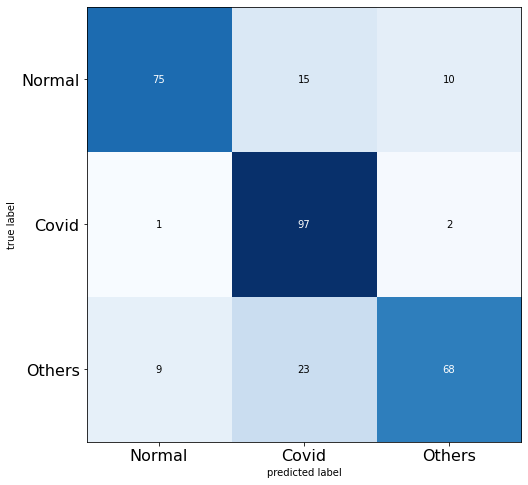

In [64]:
# Get the confusion matrix
cm  = confusion_matrix(true, predictions)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Covid', 'Others'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Covid', 'Others'], fontsize=16)
plt.savefig('/kaggle/working/confusion_matrix_EFFb7.png', dpi=100)
plt.show()

In [50]:
cm

array([[75, 15, 10],
       [ 1, 97,  2],
       [ 9, 23, 68]])

## Classification Report

In [41]:
report = classification_report(true, predictions, target_names = ['Normal', 'Covid', 'Others'])
print(report)

              precision    recall  f1-score   support

      Normal       0.88      0.75      0.81       100
       Covid       0.72      0.97      0.83       100
      Others       0.85      0.68      0.76       100

    accuracy                           0.80       300
   macro avg       0.82      0.80      0.80       300
weighted avg       0.82      0.80      0.80       300



## Sensitivity

**Sensitivity** -  is the probability that test output is positive given that the case is actually positive i.e (having a disease.)

In [60]:
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def sesitivity_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [61]:
sesitivity_macro_average(cm)

0.7999999999999999

## Specificity

**Specificity** - is the probability that test output is negative given that the case is actually negative i.e (having no disease)

In [62]:
def specificity(label, confusion_matrix):
    neg_arr = np.delete(confusion_matrix, label, axis = 0)
    return np.delete(neg_arr, label, axis = 1).sum()/neg_arr.sum()

def specificity_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_specificities = 0
    for label in range(columns):
        sum_of_specificities += specificity(label, confusion_matrix)
    return sum_of_specificities / columns

In [63]:
specificity_macro_average(cm)

0.9

## AUC

In [ ]:
# def get_roc_curve(labels, predicted_vals, generator):
#     auc_roc_vals = []
#     for i in range(len(labels)):
#         try:
#             gt = generator[:, i]
#             pred = predicted_vals[:, i]
#             auc_roc = roc_auc_score(gt, pred)
#             auc_roc_vals.append(auc_roc)
#             fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
#             plt.figure(1, figsize=(10, 10))
#             plt.plot([0, 1], [0, 1], 'k--')
#             plt.plot(fpr_rf, tpr_rf,
#                      label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
#             plt.xlabel('False positive rate')
#             plt.ylabel('True positive rate')
#             plt.title('ROC curve')
#             plt.legend(loc='best')
#         except:
#             print(
#                 f"Error in generating ROC curve for {labels[i]}. "
#                 f"Dataset lacks enough examples."
#             )
#     plt.show()
#     return auc_roc_vals

In [ ]:
# disease_labels = ['Covid', 'Normal', 'Other']
# get_roc_curve(disease_labels, pred, true)